In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
from numba import njit, prange
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy.optimize import root_scalar
import glob

from rbf.interpolate import KNearestRBFInterpolant
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5-RadFeed']
basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f


In [3]:
@njit
def process_id(ID, bar_metr, t, tlist, nsnap):
    in_bar = np.full(nsnap, 0, dtype=np.bool_)
    for j,idx in enumerate(range(nsnap)):
        Tanalyze = tlist[idx]
        key = np.argmin(np.abs(t - Tanalyze))
        
        metr = bar_metr[key]
        
        if metr[3] == 0.0:
            continue
        
        c0 = metr[1] < np.pi/8.0
        c1 = metr[2]/metr[3] < 0.22
        if c0 and c1:
            in_bar[j] = 1
    
    return in_bar

def _in_bar_one_chunk(prefix, name, chunk_idx, nsnap):
    fin = prefix+'/bar_orbit_'+name+'.' + str(chunk_idx) + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    id_list = np.array(h5in['id_list']).astype(np.int)
    tlist = np.array(h5in['tlist'])
    
    in_bar = np.full((nsnap, len(id_list)), 0, dtype=np.bool_)
    
    for i,ID in enumerate(id_list):
        bar_metr = np.array(h5in['bar_metrics'][str(ID)])
        t = tlist[bar_metr[:,0].astype(np.int)]
        in_bar[:,i] = process_id(ID, bar_metr, t, tlist, nsnap)
    
    h5in.close()
    return in_bar

def compute_in_bar(name, nproc):
    basepath = '/n/home01/abeane/starbar/plots/bar_orbits/data/'
    prefix = basepath + 'bar_orbit_' + name
    
    nchunk = len(glob.glob(prefix+'/bar_orbit_'+name+'.*.hdf5'))
    fin0 = prefix+'/bar_orbit_'+name+'.0.hdf5'
    h5in0 = h5.File(fin0, mode='r')
    
    nsnap = len(np.array(h5in0['idx_list']))
    h5in0.close()
    
    in_bar_out = Parallel(n_jobs=nproc)(delayed(_in_bar_one_chunk)(prefix, name, i, nsnap) for i in tqdm(range(nchunk)))
    
    return in_bar_out
    


In [14]:
name = 'Nbody-lvl4'

basepath = '/n/home01/abeane/starbar/plots/bar_orbits/data/'
prefix = basepath + 'bar_orbit_' + name

fin = prefix+'/bar_orbit_'+name+'.' + str(0) + '.hdf5'
h5in = h5.File(fin, mode='r')
    
id_list = np.array(h5in['id_list']).astype(np.int)
tlist = np.array(h5in['tlist'])
h5in.close()

In [5]:
in_bar_out_Nbody4 = compute_in_bar('Nbody-lvl4', 24)
in_bar_out_Nbody3 = compute_in_bar('Nbody-lvl3', 24)

A Jupyter Widget

A Jupyter Widget

In [6]:
in_bar_out_gas4 = compute_in_bar('phantom-vacuum-Sg20-Rc3.5-lvl4', 24)
in_bar_out_gas3 = compute_in_bar('phantom-vacuum-Sg20-Rc3.5-lvl3', 24)

A Jupyter Widget

A Jupyter Widget

In [77]:
R_bar = np.linalg.norm(pos_bar[:,:2], axis=1)
R_notbar = np.linalg.norm(pos_notbar[:,:2], axis=1)

V_bar = (pos_bar[:,0] * vel_bar[:,1] - pos_bar[:,1] * vel_bar[:,0]) / R_bar
V_notbar = (pos_notbar[:,0] * vel_notbar[:,1] - pos_notbar[:,1] * vel_notbar[:,0]) / R_notbar

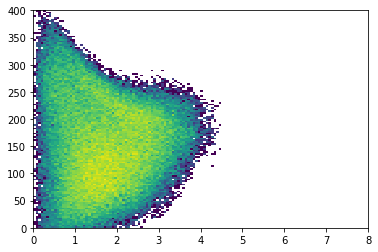

In [81]:
rng = [[0, 8.0], [0, 400]]
nres = 128

# heatmap, _, _ = np.histogram2d(metr_list[:,1], metr_list[:,2]/metr_list[:,3], range=rng, bins=(nres, nres))
heatmap, _, _ = np.histogram2d(R_bar, V_bar, range=rng, bins=(nres, nres))
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]

fig, ax = plt.subplots(1, 1)
ax.imshow(heatmap.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
plt.show()

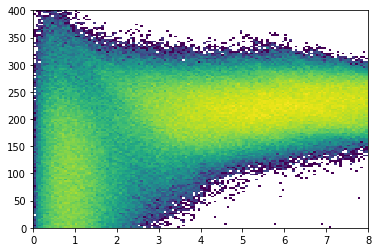

In [82]:
rng = [[0, 8.0], [0, 400]]
nres = 128

# heatmap, _, _ = np.histogram2d(metr_list[:,1], metr_list[:,2]/metr_list[:,3], range=rng, bins=(nres, nres))
heatmap, _, _ = np.histogram2d(R_notbar, V_notbar, range=rng, bins=(nres, nres))
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]

fig, ax = plt.subplots(1, 1)
ax.imshow(heatmap.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('auto')
plt.show()

In [15]:
def compute_ftrapped(in_bar):
    ftrapped_list = []
    for i in range(np.shape(in_bar)[0]):
        in_bar_snap = in_bar[i]
        frac_trapped = len(np.where(in_bar_snap)[0]) / len(in_bar_snap)
        ftrapped_list.append(frac_trapped)
    
    return ftrapped_list
        
ftrapped_list = compute_ftrapped(in_bar)
ftrapped_gas_list = compute_ftrapped(in_bar_gas)


In [7]:
def compute_ftrapped(in_bar_out):
    nsnap = np.shape(in_bar_out[0])[0]
    
    Ninbar = np.zeros(nsnap).astype(np.int)
    Ntot = np.zeros(nsnap).astype(np.int)
    
    # first loop is over chunks, second loop is over snapshots
    for in_bar in in_bar_out:
        for i in range(np.shape(in_bar)[0]):
            in_bar_snap = in_bar[i]
            Ninbar[i] += len(np.where(in_bar_snap)[0])
            Ntot[i] += len(in_bar_snap)
    
    ftrapped = np.zeros(nsnap)
    for i in range(nsnap):
        ftrapped[i] = Ninbar[i]/Ntot[i]
    
    return ftrapped

ftrapped_Nbody4 = compute_ftrapped(in_bar_out_Nbody4)
ftrapped_Nbody3 = compute_ftrapped(in_bar_out_Nbody3)
ftrapped_gas4 = compute_ftrapped(in_bar_out_gas4)
ftrapped_gas3 = compute_ftrapped(in_bar_out_gas3)



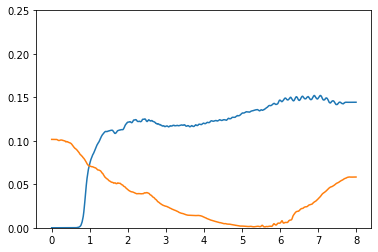

In [18]:
plt.plot(tlist, ftrapped_Nbody4)
plt.plot(tlist, ftrapped_gas4)
plt.ylim(0, 0.25)
plt.show()

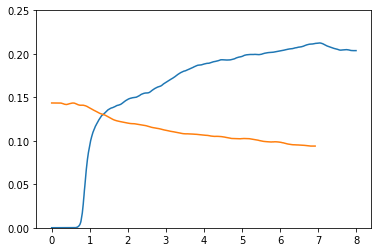

In [17]:
plt.plot(tlist, ftrapped_Nbody3)
plt.plot(tlist[:len(ftrapped_gas3)], ftrapped_gas3)
plt.ylim(0, 0.25)
plt.show()

In [22]:
def compute_bar_properties(name, mass, in_bar_out, center):
    nsnap = np.shape(in_bar_out[0])[0]
    idx_list = np.arange(0, nsnap, 50)

    phase_space_path='/n/home01/abeane/starbar/plots/phase_space/data_tmp/'
    nchunk = len(glob.glob(phase_space_path+name+'/phase_space_'+name+'.*.hdf5'))

    bar_prop_list = np.zeros((len(idx_list), 5))

    ctr = 0
    for i in tqdm(range(nchunk)):
        in_bar = in_bar_out[i]
        Mbar = 0.0
        Lzbar = 0.0
    
        fin = phase_space_path + name + '/phase_space_' + name + '.' + str(i) + '.hdf5'
        h5in = h5.File(fin, mode='r')
    
        tlist = np.array(h5in['Time'])
        pos_tot = np.array(h5in['Coordinates']) - center
        vel_tot = np.array(h5in['Velocities'])
        ids = np.array(h5in['ParticleIDs'])
    
        if i==0:
            Rlist = {}
            for idx in idx_list:
                Rlist[idx] = np.array([])
    
        for j,idx in enumerate(idx_list):
            pos = pos_tot[:,idx,:]
            vel = vel_tot[:,idx,:]
        
            key = in_bar[idx][ctr:ctr+len(ids)]
        
        
            pos_inbar = pos[key]
            vel_inbar = vel[key]

            N_inbar = len(np.where(key)[0])
    
            Mbar = mass * len(pos_inbar)
            Lzbar = mass * np.sum(np.cross(pos_inbar, vel_inbar)[:,2])
        
            bar_prop_list[j,0] = tlist[idx]
            bar_prop_list[j,3] += Mbar
            bar_prop_list[j,4] += Lzbar
        
            if N_inbar == 0:
                R = np.array([])
            elif N_inbar == 1:
                R = np.array([np.sqrt(pos_inbar[0][0]**2 + pos_inbar[0][1]**2)]).reshape((1,))
            else:
                R = np.linalg.norm(pos_inbar[:,:2], axis=1)
            Rlist[idx] = np.concatenate((Rlist[idx], R))
    
        ctr += len(ids)
    
    
    for j,idx in enumerate(idx_list):
        if len(Rlist[idx]>100):
            Rbar = np.percentile(Rlist[idx], 99)
        else:
            Rbar = 0.0
        bar_prop_list[j,2] = Rbar
    
    return bar_prop_list    



In [23]:
bar_prop_Nbody4 = compute_bar_properties('Nbody-lvl4', 6E-6, in_bar_out_Nbody4, np.array([0., 0., 0.]))

A Jupyter Widget

In [24]:
bar_prop_Nbody3 = compute_bar_properties('Nbody-lvl3', 6E-6/8.0, in_bar_out_Nbody3, np.array([0., 0., 0.]))

A Jupyter Widget

In [27]:
bar_prop_gas4 = compute_bar_properties('phantom-vacuum-Sg20-Rc3.5-lvl4', 6E-6, 
                                       in_bar_out_gas4, np.array([200., 200., 200.]))

A Jupyter Widget

In [28]:
bar_prop_gas3 = compute_bar_properties('phantom-vacuum-Sg20-Rc3.5-lvl3', 6E-6/8.0, in_bar_out_gas3, np.array([200., 200., 200.]))

A Jupyter Widget

In [27]:
idx_list = np.arange(0, 1601, 50)
bar_prop_list = []
center = np.array([0., 0., 0.])

mass = 6E-6 / 8

phase_space_path='/n/home01/abeane/starbar/plots/phase_space/data_tmp/'
name = 'Nbody-lvl3'
nchunk = len(glob.glob(phase_space_path+name+'/phase_space_'+name+'.*.hdf5'))
in_bar = in_bar_out_Nbody3

bar_prop_list = np.zeros((len(idx_list), 5))

ctr = 0
for i in tqdm(range(nchunk)):
    Mbar = 0.0
    Lzbar = 0.0
    
    fin = phase_space_path + name + '/phase_space_' + name + '.' + str(i) + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    tlist = np.array(h5in['Time'])
    pos_tot = np.array(h5in['Coordinates']) - center
    vel_tot = np.array(h5in['Velocities'])
    ids = np.array(h5in['ParticleIDs'])
    
    if i==0:
        Rlist = {}
        for idx in idx_list:
            Rlist[idx] = np.array([])
    
    for j,idx in enumerate(idx_list):
        pos = pos_tot[:,idx,:]
        vel = vel_tot[:,idx,:]
        
        key = in_bar[i][idx][ctr:ctr+len(ids)]
        
        
        pos_inbar = pos[key]
        vel_inbar = vel[key]

        N_inbar = len(np.where(key)[0])
    
        frac_trapped = len(np.where(in_bar[i][idx])[0])/len(in_bar[i][idx])
    
        Mbar = mass * len(pos_inbar)
        Lzbar = mass * np.sum(np.cross(pos_inbar, vel_inbar)[:,2])
        
        bar_prop_list[j,0] = tlist[idx]
        bar_prop_list[j,1] = frac_trapped
        bar_prop_list[j,3] += Mbar
        bar_prop_list[j,4] += Lzbar
        
        if N_inbar == 0:
            R = np.array([])
        elif N_inbar == 1:
            R = np.array([np.sqrt(pos_inbar[0][0]**2 + pos_inbar[0][1]**2)]).reshape((1,))
        else:
            R = np.linalg.norm(pos_inbar[:,:2], axis=1)
        Rlist[idx] = np.concatenate((Rlist[idx], R))
    
    ctr += len(ids)
    
    
for j,idx in enumerate(idx_list):
    Rbar = np.percentile(Rlist[idx], 99)
    bar_prop_list[j,2] = Rbar
    
# bar_prop_list = np.array(bar_prop_list)

A Jupyter Widget

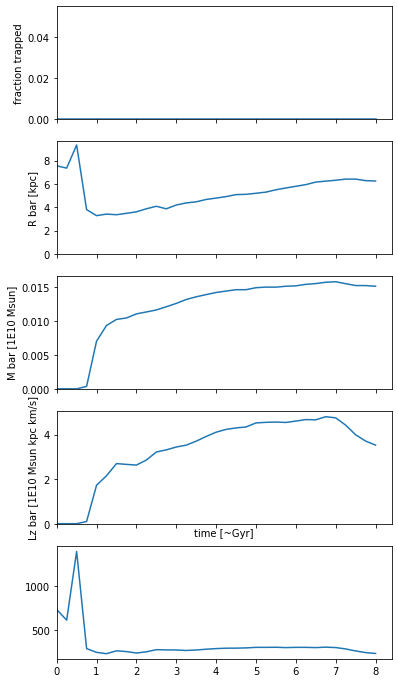

In [26]:
fig, ax = plt.subplots(5, 1, figsize=(6, 12), sharex=True)

bar_prop_list = bar_prop_Nbody3

ax[0].plot(bar_prop_list[:,0], bar_prop_list[:,1])
ax[1].plot(bar_prop_list[:,0], bar_prop_list[:,2])
ax[2].plot(bar_prop_list[:,0], bar_prop_list[:,3])
ax[3].plot(bar_prop_list[:,0], bar_prop_list[:,4])
ax[4].plot(bar_prop_list[:,0], bar_prop_list[:,4]/bar_prop_list[:,3])

ax[0].set(ylabel='fraction trapped', ylim=(0, None))
ax[3].set(xlabel='time [~Gyr]', ylabel='Lz bar [1E10 Msun kpc km/s]', ylim=(0, None))
ax[1].set(ylabel='R bar [kpc]', ylim=(0, None), xlim=(0, None))
ax[2].set(ylabel='M bar [1E10 Msun]', ylim=(0, None))

plt.show()

In [21]:
@njit
def compute_apoapses(orbit):

    # first find the apoapses
    N = len(orbit)
    rsq = np.zeros(N)
    for i in range(N):
        rsq[i] = orbit[i][0]**2 + orbit[i][1]**2 + orbit[i][2]**2

    is_apoapse = np.zeros(N)
    
    for i in range(1, N-1):
        if rsq[i] > rsq[i-1] and rsq[i] > rsq[i+1]:
            is_apoapse[i] = 1
    
    key_apo = np.where(is_apoapse==1)[0]
    apo = orbit[key_apo]
    
    return key_apo, apo

@njit
def loop_over_apoapses_compute_I(w, tlist, Trange):
    Tmin = Trange[0]
    Tmax = Trange[1]
    
    dat_out = np.zeros((w.shape[1], 4))
    
    for j in range(w.shape[1]):
        orbit = w[:,j]
        key_apo, _ = compute_apoapses(orbit[:,:3])
        t_apo = tlist[key_apo]
        
        # find the keys for the apoapses at edges of Trange
        for k in range(len(t_apo)):
            if t_apo[k] < Tmin and t_apo[k+1] > Tmin:
                Tmin_key0 = key_apo[k]
                Tmin_key1 = key_apo[k+1]
            
            if t_apo[k] < Tmax and t_apo[k+1] > Tmax:
                Tmax_key0 = key_apo[k]
                Tmax_key1 = key_apo[k+1]
                break
        
        Iz_Tmin = 0.0
        Iz_Tmax = 0.0
        Nmin = 0
        Nmax = 0
        
        for k in range(Tmin_key0, Tmin_key1):
            Iz_Tmin += (orbit[k][0]*orbit[k][4] - orbit[k][3]*orbit[k][1]) / np.sqrt(orbit[k][0]**2 + orbit[k][1]**2)
            Nmin += 1
        if Nmin > 0:
            Iz_Tmin /= float(Nmin)
        else:
            Iz_Tmin = np.nan
        
        for k in range(Tmax_key0, Tmax_key1):
            Iz_Tmax += (orbit[k][0]*orbit[k][4] - orbit[k][3]*orbit[k][1]) / np.sqrt(orbit[k][0]**2 + orbit[k][1]**2)
            Nmax += 1
        
        if Nmax > 0:
            Iz_Tmax /= float(Nmax)
        else:
            Iz_Tmax = np.nan
        
        k = Tmin_key0
        R_apo = np.sqrt(orbit[k][0]**2 + orbit[k][1]**2)
        V_apo = (orbit[k][0] * orbit[k][4] - orbit[k][3] * orbit[k][1]) / R_apo
        
        dat_out[j][0] = R_apo
        dat_out[j][1] = V_apo
        dat_out[j][2] = Iz_Tmin
        dat_out[j][3] = Iz_Tmax
        
    return dat_out
        


In [ ]:
def compute_apoapses

In [22]:
phase_space_path='/n/home01/abeane/starbar/plots/phase_space/data_tmp/'
name = 'Nbody-lvl4'

Trange = [2.5, 3.5]
center = np.array([0., 0., 0.])

nchunk = len(glob.glob(phase_space_path+name+'/phase_space_'+name+'.*.hdf5'))

dat_tot = np.array([]).reshape((0, 4))

for i in tqdm(range(nchunk)):
    fin = phase_space_path + name + '/phase_space_' + name + '.' + str(i) + '.hdf5'
    h5in = h5.File(fin, mode='r')
    
    tlist = np.array(h5in['Time'])
    pos = np.array(h5in['Coordinates']) - center
    vel = np.array(h5in['Velocities'])
        
    w = np.concatenate((pos, vel), axis=-1)
    w = np.swapaxes(w, 0, 1)
    
    dat = loop_over_apoapses_compute_I(w, tlist, Trange)
    dat_tot = np.concatenate((dat_tot, dat))
    

A Jupyter Widget

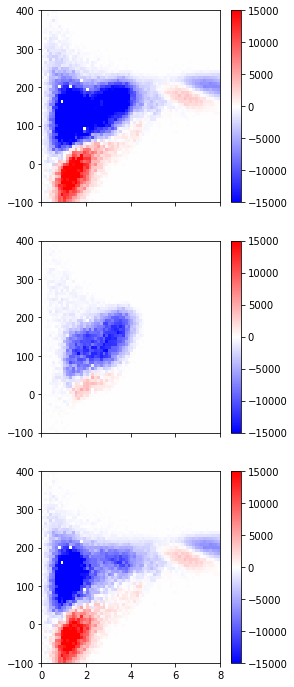

In [42]:
R_apo = dat_tot[:,0]
V_apo = dat_tot[:,1]
delta_Iz = dat_tot[:,3] - dat_tot[:,2]


rng = [[0, 8.0], [-100, 400]]
nres = 64
idx = 500
vmin = -15000
vmax = 15000

fig, ax = plt.subplots(3, 1, figsize=(4, 12), sharex=True, sharey=True)

# heatmap, _, _ = np.histogram2d(metr_list[:,1], metr_list[:,2]/metr_list[:,3], range=rng, bins=(nres, nres))
heatmap, _, _ = np.histogram2d(R_apo, V_apo, range=rng, bins=(nres, nres), weights=delta_Iz)
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
im = ax[0].imshow(heatmap.T, extent=extent, vmin=vmin, vmax=vmax, origin='lower',cmap='bwr')
fig.colorbar(im, ax=ax[0])

heatmap, _, _ = np.histogram2d(R_apo[in_bar[idx]], V_apo[in_bar[idx]], range=rng, 
                               bins=(nres, nres), weights=delta_Iz[in_bar[idx]])
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
im = ax[1].imshow(heatmap.T, extent=extent, vmin=vmin, vmax=vmax, origin='lower',cmap='bwr')
fig.colorbar(im, ax=ax[1])

not_in_bar = np.logical_not(in_bar[idx])
heatmap, _, _ = np.histogram2d(R_apo[not_in_bar], V_apo[not_in_bar], range=rng, 
                               bins=(nres, nres), weights=delta_Iz[not_in_bar])
extent = [rng[0][0], rng[0][1], rng[1][0], rng[1][1]]
im = ax[2].imshow(heatmap.T, extent=extent, vmin=vmin, vmax=vmax, origin='lower',cmap='bwr')
fig.colorbar(im, ax=ax[2])

ax[0].set_aspect('auto')
ax[1].set_aspect('auto')
ax[2].set_aspect('auto')
plt.show()

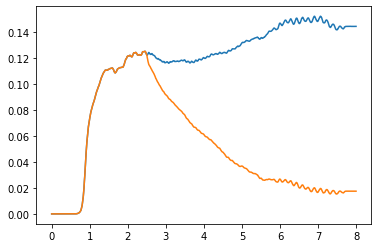

In [80]:
ftrapped_list = []
ftrapped_from_idx = []
idx = 500
for i in range(np.shape(in_bar)[0]):
    in_bar_snap = in_bar[i]
    frac_trapped = len(np.where(in_bar_snap)[0]) / len(in_bar_snap)
    ftrapped_list.append(frac_trapped)
    
    if i<= idx:
        ftrapped_from_idx.append(frac_trapped)
    else:
        t = len(np.where(np.logical_and(in_bar[idx], in_bar_snap))[0])/len(in_bar_snap)
        ftrapped_from_idx.append(t)

plt.plot(tlist[:1600], ftrapped_list)
plt.plot(tlist[:1600], ftrapped_from_idx)
plt.show()

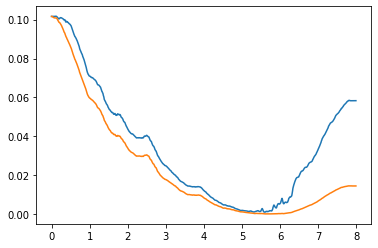

In [20]:
ftrapped_list = []
ftrapped_from_idx = []
idx = 0
for i in range(np.shape(in_bar_gas)[0]):
    in_bar_snap = in_bar_gas[i]
    frac_trapped = len(np.where(in_bar_snap)[0]) / len(in_bar_snap)
    ftrapped_list.append(frac_trapped)
    
    if i<= idx:
        ftrapped_from_idx.append(frac_trapped)
    else:
        t = len(np.where(np.logical_and(in_bar_gas[idx], in_bar_snap))[0])/len(in_bar_snap)
        ftrapped_from_idx.append(t)

plt.plot(tlist[:1600], ftrapped_list)
plt.plot(tlist[:1600], ftrapped_from_idx)
plt.show()